# Post Processing and Evaluation Script

## 🧪 Named Entity Recognition (NER) Pipeline Overview

This notebook evaluates the performance of a fine-tuned NER model designed to extract biological entity mentions (e.g., species names) from scientific text.

---

### 🔄 Step 1: Post-processing of Raw NER Predictions

Before evaluation, we apply a post-processing function to clean the model's predictions:

- **Remove generic or ambiguous taxonomic terms** (e.g., "mammals", "organisms", "predators") using a curated exclusion list.
- **Normalize annotation text**:
  - Trim whitespace
  - Remove unnecessary punctuation
  - Lowercase and optionally lemmatize for robust filtering
- **Drop empty or null entries**
- **Remove duplicate entity annotations** (based on document ID + entity text)

📁 **Taxonomic Filtering List:**  
A plain text file (`taxonomic_terms_list.txt`) containing domain-general biological terms that are **not valid species names**.

📂 **Output:** A cleaned CSV file of predictions ready for evaluation.

---

### 📊 Step 2: Multi-Level NER Evaluation

We compare cleaned predictions to ground truth annotations using multiple match strategies:

#### 🔍 Matching Strategies:
- **Exact Match**: Entity text and positions match exactly (±5 characters allowed)
- **Partial Match**: One text is a substring of the other
- **Enhanced Match**: Combines:
  - Exact
  - Substring
  - Fuzzy matching (threshold ≥ 0.8)
  - Word overlap
- **Optimal Match**: Uses global alignment (Hungarian-style algorithm) to minimize mismatches

#### 📈 Metrics Computed:
- **Precision**: % of predicted entities that are correct
- **Recall**: % of ground truth entities recovered
- **F1 Score**: Harmonic mean of precision and recall
- **TP / FP / FN**: True Positives, False Positives, False Negatives

---
### 📉 Step 3: Visual Evaluation of Model Performance

A set of diagnostic plots is provided to better understand model behavior and common error patterns:

- **Performance Metrics Bar Chart**  
  Displays precision, recall, and F1-score for each evaluation strategy

---

### 🎯 Goal

These steps provide a clear, interpretable evaluation of the NER system's ability to extract meaningful species-related mentions, while eliminating generic or misleading terms. This is essential for building accurate species interaction graphs and downstream ecological analyses.


### Post-Processing 

In [2]:
import pandas as pd
import re

def load_taxonomic_terms(file_path):
    """Load the list of generic taxonomic terms to filter out."""
    with open(file_path, 'r', encoding='utf-8') as f:
        terms = [line.strip().lower() for line in f if line.strip()]
    return set(terms)

def simple_post_process(input_csv_path, output_csv_path, taxonomic_terms_path):
    """
    Simple post-processing: remove generic terms, clean text.
    
    Parameters:
    - input_csv_path: Path to the raw NER results CSV
    - output_csv_path: Path to save the cleaned results
    - taxonomic_terms_path: Path to taxonomic terms list to filter out
    
    Returns:
    - cleaned_df: Processed DataFrame
    """
    
    # Load the results
    df = pd.read_csv(input_csv_path)
    print(f"Loaded {len(df)} annotations from {input_csv_path}")
    
    # Load taxonomic terms to filter out
    taxonomic_terms = load_taxonomic_terms(taxonomic_terms_path)
    print(f"Loaded {len(taxonomic_terms)} taxonomic terms to filter out")
    
    # Remove empty annotations
    initial_count = len(df)
    df = df[df['Annotation Text'].notna() & (df['Annotation Text'] != '')]
    print(f"Removed {initial_count - len(df)} empty annotations")
    
    # Clean annotation text - remove extra spaces and normalize
    def clean_text(text):
        if pd.isna(text):
            return ''
        # Convert to string and strip
        text = str(text).strip()
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        return text
    
    df['Annotation Text'] = df['Annotation Text'].apply(clean_text)
    
    # Filter out generic taxonomic terms
    def is_not_generic_term(text):
        if pd.isna(text) or text == '':
            return False
        # Convert to lowercase for comparison
        text_lower = text.lower().strip()
        # Check if it's in the generic terms list
        return text_lower not in taxonomic_terms
    
    before_filter = len(df)
    df = df[df['Annotation Text'].apply(is_not_generic_term)]
    print(f"Removed {before_filter - len(df)} generic taxonomic terms")
    
    # Save the cleaned results
    df.to_csv(output_csv_path, index=False)
    print(f"\nPost-processing complete!")
    print(f"Final result: {len(df)} annotations saved to {output_csv_path}")
    
    # Print summary
    print(f"\nSummary:")
    print(f"- Documents processed: {df['doc_id'].nunique()}")
    print(f"- Average annotations per document: {len(df) / df['doc_id'].nunique():.1f}")
    
    return df


### Evaluation

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from rapidfuzz import fuzz
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

def load_ground_truth_from_csv(file_path):
    """
    Load ground truth from the CSV file with no headers.
    The data has 5 columns:
    - Column 1: Numeric ID (e.g., 75485)
    - Column 2: Document ID (e.g., "species012")
    - Column 3: Start position (e.g., 361)
    - Column 4: End position (e.g., 382)
    - Column 5: Entity text (e.g., "black-legged kittiwake")
    """
    print(f"Loading ground truth from: {file_path}")
    
    # Read the CSV with no headers
    df = pd.read_csv(file_path)
    
    # Initialize annotations dictionary
    annotations = defaultdict(list)
    
    # Process each row
    for _, row in df.iterrows():
        doc_id = row['doc_id']
        start_pos = int(row['start'])
        end_pos = int(row['end'])
        entity_text = row['Annotation Text']
        label = row['label']
        
        annotations[doc_id].append({
            'text': entity_text,
            'start': start_pos,
            'end': end_pos,
            'label': label
        })
    
    print(f"Loaded ground truth for {len(annotations)} documents with {sum(len(entities) for entities in annotations.values())} entities")
    return annotations

def prepare_predictions(results_df):
    """
    Convert prediction DataFrame to the format needed for evaluation.
    Use the doc_id column directly, just strip the .txt extension if present.
    """
    print("Preparing predictions...")
    fixed_df = results_df.copy()
    
    # Clean up document IDs - strip .txt extension if present
    fixed_df['clean_doc_id'] = fixed_df['doc_id'].apply(lambda x: x.replace('.txt', '') if isinstance(x, str) else x)
    
    # Adjust end positions (subtract 1 to match ground truth convention)
    fixed_df['original_end'] = fixed_df['end']
    fixed_df['end'] = fixed_df['end'].apply(lambda x: int(x)-1 if pd.notnull(x) else x)
    
    # Group by document
    pred_data = defaultdict(list)
    
    for _, row in fixed_df.iterrows():
        doc_id = row['clean_doc_id']
        
        # Skip if positions are missing or invalid
        if pd.isna(row['start']) or pd.isna(row['end']):
            continue
        
        pred_data[doc_id].append({
            'text': row['Annotation Text'],
            'start': int(row['start']),
            'end': int(row['end']),  # Already adjusted
            'label': 'Species'  # Standardize to Species
        })
    
    print(f"Prepared predictions for {len(pred_data)} documents with {sum(len(entities) for entities in pred_data.values())} entities")
    return pred_data, fixed_df

def calculate_exact_match_metrics(gt_data, pred_data, position_tolerance=5):
    """Calculate exact match metrics with proper entity alignment."""
    total_gt = sum(len(entities) for entities in gt_data.values())
    total_pred = sum(len(entities) for entities in pred_data.values())
    
    true_positives = 0
    match_details = []
    
    # Count matches
    for doc_id, gt_entities in gt_data.items():
        if doc_id not in pred_data:
            continue
            
        pred_entities = pred_data[doc_id]
        
        # Track which predictions are matched
        matched_preds = set()
        
        for gt_entity in gt_entities:
            gt_text = gt_entity['text'].lower()
            
            for i, pred_entity in enumerate(pred_entities):
                if i in matched_preds:
                    continue  # Skip already matched predictions
                
                pred_text = pred_entity['text'].lower()
                
                # Check for exact match (text and position)
                text_match = gt_text == pred_text
                start_match = abs(gt_entity['start'] - pred_entity['start']) <= position_tolerance
                end_match = abs(gt_entity['end'] - pred_entity['end']) <= position_tolerance
                
                if text_match and start_match and end_match:
                    true_positives += 1
                    matched_preds.add(i)
                    match_details.append({
                        'doc_id': doc_id,
                        'gt_text': gt_entity['text'],
                        'pred_text': pred_entity['text'],
                        'gt_start': gt_entity['start'],
                        'pred_start': pred_entity['start'],
                        'gt_end': gt_entity['end'],
                        'pred_end': pred_entity['end']
                    })
                    break
    
    # Calculate metrics
    precision = true_positives / total_pred if total_pred > 0 else 0
    recall = true_positives / total_gt if total_gt > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': total_pred - true_positives,
        'false_negatives': total_gt - true_positives,
        'match_details': match_details
    }

def calculate_partial_match_metrics(gt_data, pred_data, verbose=False):
    """Calculate partial match metrics (substring matching only)."""
    total_gt = sum(len(entities) for entities in gt_data.values())
    total_pred = sum(len(entities) for entities in pred_data.values())
    
    true_positives = 0
    match_details = []
    
    # Count matches
    for doc_id, gt_entities in gt_data.items():
        if doc_id not in pred_data:
            continue
            
        pred_entities = pred_data[doc_id]
        
        # Track which predictions are matched
        matched_preds = set()
        
        for gt_entity in gt_entities:
            gt_text = gt_entity['text'].lower()
            
            for i, pred_entity in enumerate(pred_entities):
                if i in matched_preds:
                    continue  # Skip already matched predictions
                
                pred_text = pred_entity['text'].lower()
                
                # Check for partial text match (substring relationship)
                if (gt_text in pred_text or pred_text in gt_text):
                    true_positives += 1
                    matched_preds.add(i)
                    match_details.append({
                        'doc_id': doc_id,
                        'gt_text': gt_entity['text'],
                        'pred_text': pred_entity['text'],
                        'match_type': 'substring'
                    })
                    if verbose:
                        print(f"Substring match: '{gt_text}' <-> '{pred_text}'")
                    break
    
    # Calculate metrics
    precision = true_positives / total_pred if total_pred > 0 else 0
    recall = true_positives / total_gt if total_gt > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': total_pred - true_positives,
        'false_negatives': total_gt - true_positives,
        'match_details': match_details
    }

def calculate_enhanced_partial_match_metrics(gt_data, pred_data, 
                                           use_fuzzy=True, 
                                           fuzzy_threshold=0.8,
                                           use_word_overlap=True,
                                           verbose=False):
    """Enhanced partial matching with multiple strategies."""
    total_gt = sum(len(entities) for entities in gt_data.values())
    total_pred = sum(len(entities) for entities in pred_data.values())
    
    true_positives = 0
    match_details = []
    
    for doc_id, gt_entities in gt_data.items():
        if doc_id not in pred_data:
            continue
            
        pred_entities = pred_data[doc_id]
        matched_preds = set()
        
        for gt_entity in gt_entities:
            gt_text = gt_entity['text'].lower().strip()
            
            for i, pred_entity in enumerate(pred_entities):
                if i in matched_preds:
                    continue
                
                pred_text = pred_entity['text'].lower().strip()
                match_type = None
                similarity_score = 0
                
                # Strategy 1: Exact match
                if gt_text == pred_text:
                    match_type = "exact"
                    similarity_score = 1.0
                
                # Strategy 2: Substring match
                elif gt_text in pred_text or pred_text in gt_text:
                    match_type = "substring"
                    similarity_score = min(len(gt_text), len(pred_text)) / max(len(gt_text), len(pred_text))
                
                # Strategy 3: Fuzzy string matching
                elif use_fuzzy:
                    fuzzy_score = fuzz.ratio(gt_text, pred_text) / 100.0
                    if fuzzy_score >= fuzzy_threshold:
                        match_type = "fuzzy"
                        similarity_score = fuzzy_score
                
                # Strategy 4: Word overlap (for multi-word entities)
                elif use_word_overlap and len(gt_text.split()) > 1:
                    gt_words = set(gt_text.split())
                    pred_words = set(pred_text.split())
                    overlap = gt_words.intersection(pred_words)
                    if len(overlap) > 0:
                        match_type = "word_overlap"
                        similarity_score = len(overlap) / len(gt_words.union(pred_words))
                
                if match_type:
                    true_positives += 1
                    matched_preds.add(i)
                    match_details.append({
                        'doc_id': doc_id,
                        'gt_text': gt_entity['text'],
                        'pred_text': pred_entity['text'],
                        'match_type': match_type,
                        'similarity': similarity_score
                    })
                    if verbose:
                        print(f"{match_type.title()} match (sim={similarity_score:.3f}): '{gt_text}' <-> '{pred_text}'")
                    break
    
    # Calculate metrics
    precision = true_positives / total_pred if total_pred > 0 else 0
    recall = true_positives / total_gt if total_gt > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': total_pred - true_positives,
        'false_negatives': total_gt - true_positives,
        'match_details': match_details
    }

def optimal_entity_matching(gt_entities, pred_entities, similarity_threshold=0.8):
    """
    Optimal entity matching using Hungarian algorithm concept.
    Instead of greedy matching, finds the best overall alignment.
    """
    if not gt_entities or not pred_entities:
        return []
    
    # Create similarity matrix
    similarity_matrix = np.zeros((len(gt_entities), len(pred_entities)))
    
    for i, gt_entity in enumerate(gt_entities):
        gt_text = gt_entity['text'].lower().strip()
        
        for j, pred_entity in enumerate(pred_entities):
            pred_text = pred_entity['text'].lower().strip()
            
            # Calculate similarity score
            if gt_text == pred_text:
                similarity_matrix[i][j] = 1.0
            elif gt_text in pred_text or pred_text in gt_text:
                similarity_matrix[i][j] = 0.9
            else:
                fuzzy_score = fuzz.ratio(gt_text, pred_text) / 100.0
                if fuzzy_score >= similarity_threshold:
                    similarity_matrix[i][j] = fuzzy_score
    
    # Find optimal matching (simplified greedy approach)
    matches = []
    used_preds = set()
    
    # Sort by similarity scores (highest first)
    potential_matches = []
    for i in range(len(gt_entities)):
        for j in range(len(pred_entities)):
            if similarity_matrix[i][j] > similarity_threshold:
                potential_matches.append((i, j, similarity_matrix[i][j]))
    
    potential_matches.sort(key=lambda x: x[2], reverse=True)
    used_gt = set()
    
    for i, j, score in potential_matches:
        if i not in used_gt and j not in used_preds:
            matches.append((i, j, score))
            used_gt.add(i)
            used_preds.add(j)
    
    return matches

def calculate_optimal_match_metrics(gt_data, pred_data, similarity_threshold=0.8):
    """Calculate metrics using optimal entity matching."""
    total_gt = sum(len(entities) for entities in gt_data.values())
    total_pred = sum(len(entities) for entities in pred_data.values())
    
    true_positives = 0
    match_details = []
    
    for doc_id, gt_entities in gt_data.items():
        if doc_id not in pred_data:
            continue
            
        pred_entities = pred_data[doc_id]
        matches = optimal_entity_matching(gt_entities, pred_entities, similarity_threshold)
        
        for gt_idx, pred_idx, similarity in matches:
            true_positives += 1
            match_details.append({
                'doc_id': doc_id,
                'gt_text': gt_entities[gt_idx]['text'],
                'pred_text': pred_entities[pred_idx]['text'],
                'similarity': similarity,
                'match_type': 'optimal'
            })
    
    # Calculate metrics
    precision = true_positives / total_pred if total_pred > 0 else 0
    recall = true_positives / total_gt if total_gt > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': total_pred - true_positives,
        'false_negatives': total_gt - true_positives,
        'match_details': match_details
    }

def analyze_document_id_mismatches(gt_data, pred_data):
    """Analyze document ID mismatches between ground truth and predictions."""
    # Extract document IDs
    gt_docs = set(gt_data.keys())
    pred_docs = set(pred_data.keys())
    
    # Find overlaps and differences
    common_docs = gt_docs.intersection(pred_docs)
    only_in_gt = gt_docs - pred_docs
    only_in_pred = pred_docs - gt_docs
    
    print("\nDocument ID Analysis:")
    print(f"Ground truth documents: {len(gt_docs)}")
    print(f"Prediction documents: {len(pred_docs)}")
    print(f"Common documents: {len(common_docs)} ({len(common_docs)/len(gt_docs)*100:.2f}% coverage)")
    print(f"Documents only in ground truth: {len(only_in_gt)}")
    if len(only_in_gt) <= 10:
        print(f"  IDs: {sorted(only_in_gt)}")
    print(f"Documents only in predictions: {len(only_in_pred)}")
    if len(only_in_pred) <= 10:
        print(f"  IDs: {sorted(only_in_pred)}")
    elif len(only_in_pred) > 10:
        print(f"  IDs: {sorted(list(only_in_pred))}")
    
    return {
        'common_docs': common_docs,
        'only_in_gt': only_in_gt,
        'only_in_pred': only_in_pred
    }

def analyze_errors(gt_data, pred_data, use_enhanced_matching=True):
    """Analyze common error patterns."""
    missed_entities = []
    false_positives = []
    
    # Find missed entities (false negatives)
    for doc_id, gt_entities in gt_data.items():
        doc_preds = pred_data.get(doc_id, [])
        
        for gt_entity in gt_entities:
            gt_text = str(gt_entity['text']).lower().strip() if pd.notnull(gt_entity['text']) else ""
            found = False
            
            for pred_entity in doc_preds:
                pred_text = str(pred_entity['text']).lower().strip() if pd.notnull(pred_entity['text']) else ""

                # Check for match (using partial matching for error analysis)
                if use_enhanced_matching:
                    # Use multiple matching strategies
                    exact_match = gt_text == pred_text
                    substring_match = (gt_text in pred_text or pred_text in gt_text)
                    fuzzy_match = fuzz.ratio(gt_text, pred_text) / 100.0 >= 0.8
                    
                    if exact_match or substring_match or fuzzy_match:
                        found = True
                        break
                else:
                    # Original substring matching
                    if (gt_text in pred_text or pred_text in gt_text):
                        found = True
                        break
            
            if not found:
                missed_entities.append({
                    'doc_id': doc_id,
                    'text': gt_entity['text']
                })
    
    # Find false positives
    for doc_id, pred_entities in pred_data.items():
        doc_gt = gt_data.get(doc_id, [])
        
        for pred_entity in pred_entities:
            pred_text = str(pred_entity['text']).lower().strip() if pd.notnull(pred_entity['text']) else ""
            found = False
            
            for gt_entity in doc_gt:
                gt_text = str(gt_entity['text']).lower().strip() if pd.notnull(gt_entity['text']) else ""
                
                # Check for match
                if use_enhanced_matching:
                    exact_match = gt_text == pred_text
                    substring_match = (gt_text in pred_text or pred_text in gt_text)
                    fuzzy_match = fuzz.ratio(gt_text, pred_text) / 100.0 >= 0.8
                    
                    if exact_match or substring_match or fuzzy_match:
                        found = True
                        break
                else:
                    if (gt_text in pred_text or pred_text in gt_text):
                        found = True
                        break
            
            if not found:
                false_positives.append({
                    'doc_id': doc_id,
                    'text': pred_entity['text']
                })
    
    return {
        'missed_entities': missed_entities[:20],  # Return top 20 for analysis
        'false_positives': false_positives[:50]   # Return top 50 for analysis
    }

def analyze_match_quality(match_details):
    """Analyze the quality and distribution of matches."""
    if not match_details:
        return {}
    
    match_types = {}
    similarity_stats = []
    
    for match in match_details:
        match_type = match.get('match_type', 'unknown')
        similarity = match.get('similarity', 1.0)
        
        if match_type not in match_types:
            match_types[match_type] = 0
        match_types[match_type] += 1
        similarity_stats.append(similarity)
    
    if similarity_stats:
        return {
            'match_type_distribution': match_types,
            'avg_similarity': np.mean(similarity_stats),
            'min_similarity': np.min(similarity_stats),
            'max_similarity': np.max(similarity_stats),
            'similarity_std': np.std(similarity_stats) if len(similarity_stats) > 1 else 0
        }
    else:
        return {
            'match_type_distribution': match_types,
            'avg_similarity': 0,
            'min_similarity': 0,
            'max_similarity': 0,
            'similarity_std': 0
        }

def create_evaluation_summary(results):
    """Create a comprehensive evaluation summary."""
    summary = {
        'dataset_info': {
            'total_gt_entities': sum(len(entities) for entities in results['gt_data'].values()),
            'total_pred_entities': sum(len(entities) for entities in results['pred_data'].values()),
            'total_documents': len(results['gt_data']),
            'documents_with_predictions': len(results['pred_data']),
            'document_coverage': len(results['doc_analysis']['common_docs']) / len(results['gt_data'])
        },
        'performance_metrics': {
            'exact_match': results['exact_metrics'],
            'partial_match': results['partial_metrics']
        }
    }
    
    # Add enhanced metrics if available
    if 'enhanced_metrics' in results:
        summary['performance_metrics']['enhanced_match'] = results['enhanced_metrics']
        summary['match_quality_analysis'] = analyze_match_quality(results['enhanced_metrics']['match_details'])
    
    if 'optimal_metrics' in results:
        summary['performance_metrics']['optimal_match'] = results['optimal_metrics']
    
    return summary

def print_detailed_results(results):
    """Print comprehensive evaluation results."""
    print("\n" + "="*60)
    print("COMPREHENSIVE NER EVALUATION RESULTS")
    print("="*60)
    
    # Dataset information
    total_gt = sum(len(entities) for entities in results['gt_data'].values())
    total_pred = sum(len(entities) for entities in results['pred_data'].values())
    
    print(f"\nDataset Information:")
    print(f"├── Ground truth entities: {total_gt}")
    print(f"├── Predicted entities: {total_pred}")
    print(f"├── Total documents: {len(results['gt_data'])}")
    print(f"├── Documents with predictions: {len(results['pred_data'])}")
    print(f"└── Document coverage: {len(results['doc_analysis']['common_docs'])/len(results['gt_data'])*100:.1f}%")
    
    # Performance metrics
    print(f"\nPerformance Metrics:")
    print("-" * 40)
    
    metrics_to_show = [
        ('Exact Match', results['exact_metrics']),
        ('Partial Match (Substring)', results['partial_metrics'])
    ]
    
    if 'enhanced_metrics' in results:
        metrics_to_show.append(('Enhanced Match (Multi-strategy)', results['enhanced_metrics']))
    
    if 'optimal_metrics' in results:
        metrics_to_show.append(('Optimal Match', results['optimal_metrics']))
    
    for name, metrics in metrics_to_show:
        print(f"\n{name}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1 Score:  {metrics['f1']:.4f}")
        print(f"  TP: {metrics['true_positives']}, FP: {metrics['false_positives']}, FN: {metrics['false_negatives']}")
    
    # Match quality analysis
    if 'enhanced_metrics' in results:
        quality = analyze_match_quality(results['enhanced_metrics']['match_details'])
        if quality:
            print(f"\nMatch Quality Analysis:")
            print(f"  Match type distribution: {quality['match_type_distribution']}")
            print(f"  Average similarity: {quality['avg_similarity']:.3f}")
            print(f"  Similarity range: [{quality['min_similarity']:.3f}, {quality['max_similarity']:.3f}]")
    
    # Error analysis
    print(f"\nError Analysis:")
    print("-" * 40)
    
    print("Top Missed Entities (False Negatives):")
    for i, entity in enumerate(results['error_analysis']['missed_entities'][:10], 1):
        print(f"  {i:2d}. {entity['text']} ({entity['doc_id']})")
    
    print("\nTop False Positives:")
    for i, entity in enumerate(results['error_analysis']['false_positives'][:10], 1):
        print(f"  {i:2d}. {entity['text']} ({entity['doc_id']})")

def evaluate_ner_pipeline(predictions_file, ground_truth_file, 
                         use_enhanced_matching=True,
                         use_optimal_matching=False,
                         fuzzy_threshold=0.8,
                         position_tolerance=5,
                         verbose=False):
    """Complete evaluation of NER pipeline with multiple matching strategies."""
    print("="*50)
    print("ENHANCED NER PIPELINE EVALUATION")
    print("="*50)
    
    # Step 1: Load ground truth
    gt_data = load_ground_truth_from_csv(ground_truth_file)
    
    # Step 2: Load and prepare predictions
    results_df = pd.read_csv(predictions_file)
    pred_data, fixed_df = prepare_predictions(results_df)
    
    # Step 3: Analyze document ID mismatches
    doc_analysis = analyze_document_id_mismatches(gt_data, pred_data)
    
    # Step 4: Calculate metrics
    print("\nCalculating metrics...")
    
    # Exact match metrics
    exact_metrics = calculate_exact_match_metrics(gt_data, pred_data, position_tolerance)
    
    # Partial match metrics (original substring method)
    partial_metrics = calculate_partial_match_metrics(gt_data, pred_data, verbose)
    
    results = {
        'fixed_df': fixed_df,
        'gt_data': gt_data,
        'pred_data': pred_data,
        'exact_metrics': exact_metrics,
        'partial_metrics': partial_metrics,
        'doc_analysis': doc_analysis
    }
    
    # Enhanced partial match metrics
    if use_enhanced_matching:
        enhanced_metrics = calculate_enhanced_partial_match_metrics(
            gt_data, pred_data, 
            use_fuzzy=True, 
            fuzzy_threshold=fuzzy_threshold,
            use_word_overlap=True,
            verbose=verbose
        )
        results['enhanced_metrics'] = enhanced_metrics
    
    # Optimal matching metrics
    if use_optimal_matching:
        optimal_metrics = calculate_optimal_match_metrics(gt_data, pred_data, fuzzy_threshold)
        results['optimal_metrics'] = optimal_metrics
    
    # Step 5: Error analysis
    error_analysis = analyze_errors(gt_data, pred_data, use_enhanced_matching)
    results['error_analysis'] = error_analysis
    
    # Step 6: Print results
    print_detailed_results(results)
    
    # Step 7: Create summary
    results['summary'] = create_evaluation_summary(results)
    
    return results

# Example usage and testing functions
def test_matching_examples():
    """Test different matching approaches with examples."""
    
    examples = [
        ("zebra", "zbera"),          # Rearranged characters
        ("cat", "cats"),             # Substring
        ("big cat", "cat"),          # Reverse substring
        ("red fox", "red wolf"),     # Word overlap
        ("eagle", "bald eagle"),     # Substring
        ("sparrow", "sparow"),       # Typo
        ("Homo sapiens", "homo sapiens"),  # Case difference
        ("E. coli", "Escherichia coli"),   # Abbreviation
    ]
    
    print("Matching Strategy Comparison:")
    print("=" * 80)
    print(f"{'Ground Truth':<20} {'Prediction':<20} {'Substring':<10} {'Fuzzy(0.7)':<10} {'Word Overlap':<12}")
    print("-" * 80)
    
    for gt, pred in examples:
        # Current substring method
        substring_match = (gt.lower() in pred.lower() or pred.lower() in gt.lower())
        
        # Fuzzy matching
        similarity = fuzz.ratio(gt.lower(), pred.lower()) / 100.0
        fuzzy_match = similarity >= 0.8
        
        # Word overlap
        gt_words = set(gt.lower().split())
        pred_words = set(pred.lower().split())
        word_overlap = len(gt_words.intersection(pred_words)) > 0
        
        print(f"{gt:<20} {pred:<20} {str(substring_match):<10} {str(fuzzy_match):<10} {str(word_overlap):<12}")

### Visualize the Performance 

In [4]:
def plot_performance_metrics_bar(results):
    """
    Plot precision, recall, and F1-score for different matching strategies.
    Input: results from evaluate_ner_pipeline(...)
    """
    strategies = []
    precisions = []
    recalls = []
    f1s = []

    if 'exact_metrics' in results:
        strategies.append("Exact")
        precisions.append(results['exact_metrics']['precision'])
        recalls.append(results['exact_metrics']['recall'])
        f1s.append(results['exact_metrics']['f1'])

    if 'partial_metrics' in results:
        strategies.append("Partial")
        precisions.append(results['partial_metrics']['precision'])
        recalls.append(results['partial_metrics']['recall'])
        f1s.append(results['partial_metrics']['f1'])

    if 'enhanced_metrics' in results:
        strategies.append("Enhanced")
        precisions.append(results['enhanced_metrics']['precision'])
        recalls.append(results['enhanced_metrics']['recall'])
        f1s.append(results['enhanced_metrics']['f1'])

    if 'optimal_metrics' in results:
        strategies.append("Optimal")
        precisions.append(results['optimal_metrics']['precision'])
        recalls.append(results['optimal_metrics']['recall'])
        f1s.append(results['optimal_metrics']['f1'])

    df = pd.DataFrame({
        'Strategy': strategies * 3,
        'Metric': ['Precision'] * len(strategies) + ['Recall'] * len(strategies) + ['F1 Score'] * len(strategies),
        'Score': precisions + recalls + f1s
    })

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, x='Strategy', y='Score', hue='Metric')
    plt.title("NER Performance Metrics by Matching Strategy")
    plt.ylim(0, 1.05)
    plt.ylabel("Score")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


## Run 

## LLaMA 3.2 3B

### Chunk 256

Loaded 231 annotations from ./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama_3_2_3b_temp01.csv
Loaded 224 taxonomic terms to filter out
Removed 33 empty annotations
Removed 7 generic taxonomic terms

Post-processing complete!
Final result: 191 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama_3_2_3b_temp01_post.csv

Summary:
- Documents processed: 66
- Average annotations per document: 2.9
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 66 documents with 191 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 66
Common documents: 55 (80.88% coverage)
Documents only in ground truth: 13
Documents only in predictions: 11
  IDs: ['species038', 'species070', 'species315', 'species320', 'species322', 'species370', 'species537', 'species551', 'species584',

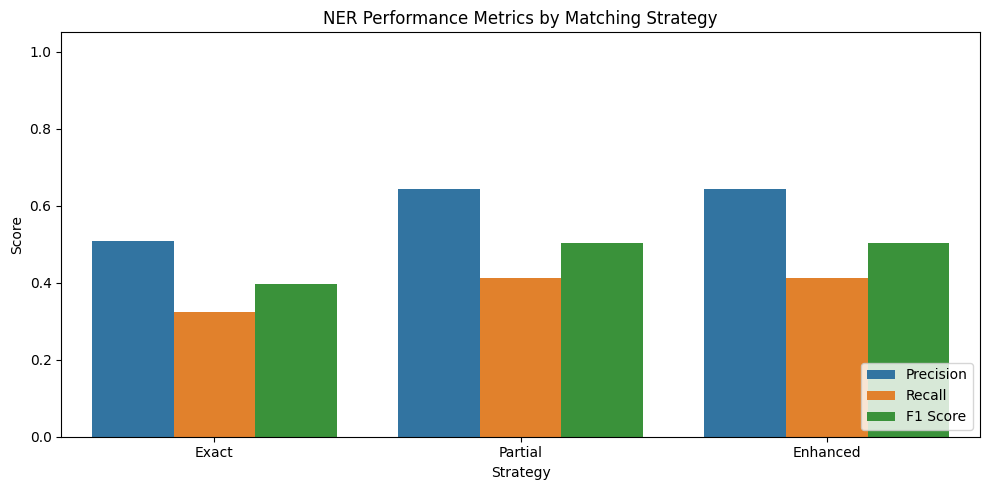

In [67]:
# LLaMA 3.2 temp 01
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama_3_2_3b_temp01.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama_3_2_3b_temp01_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama_3_2_3b_temp01_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 246 annotations from ./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_2_3b_temp3.csv
Loaded 224 taxonomic terms to filter out
Removed 29 empty annotations
Removed 10 generic taxonomic terms

Post-processing complete!
Final result: 207 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_2_3b_temp3_post.csv

Summary:
- Documents processed: 70
- Average annotations per document: 3.0
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 70 documents with 207 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 70
Common documents: 58 (85.29% coverage)
Documents only in ground truth: 10
  IDs: ['species012', 'species036', 'species042', 'species286', 'species413', 'species432', 'species458', 'species494', 'species731', 'species739']
Documents only in pred

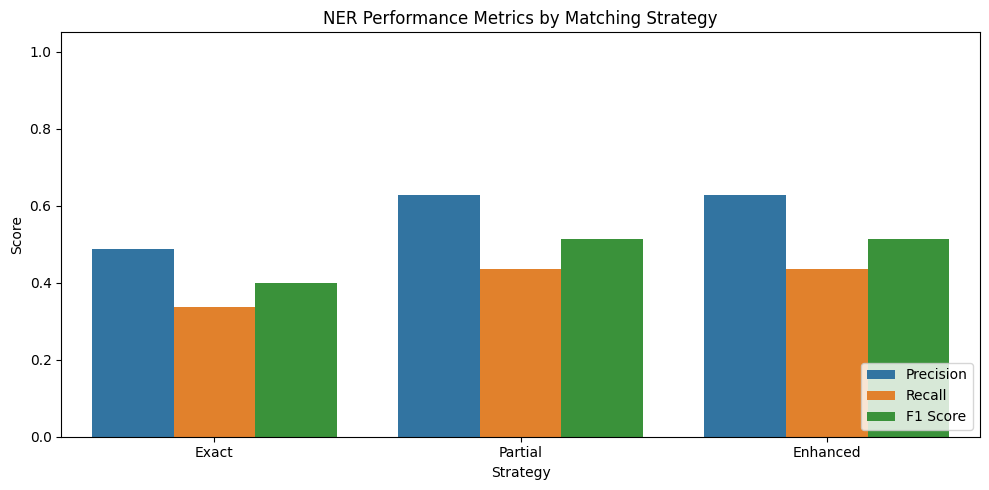

In [68]:
# LLaMA 3.2 temp 03
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_2_3b_temp3.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_2_3b_temp3_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_2_3b_temp3_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 252 annotations from ./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_2_3b_temp5.csv
Loaded 224 taxonomic terms to filter out
Removed 28 empty annotations
Removed 16 generic taxonomic terms

Post-processing complete!
Final result: 208 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_2_3b_temp5_post.csv

Summary:
- Documents processed: 71
- Average annotations per document: 2.9
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 71 documents with 208 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 71
Common documents: 56 (82.35% coverage)
Documents only in ground truth: 12
Documents only in predictions: 15
  IDs: ['species035', 'species038', 'species050', 'species070', 'species291', 'species315', 'species320', 'species322', 'species370', 's

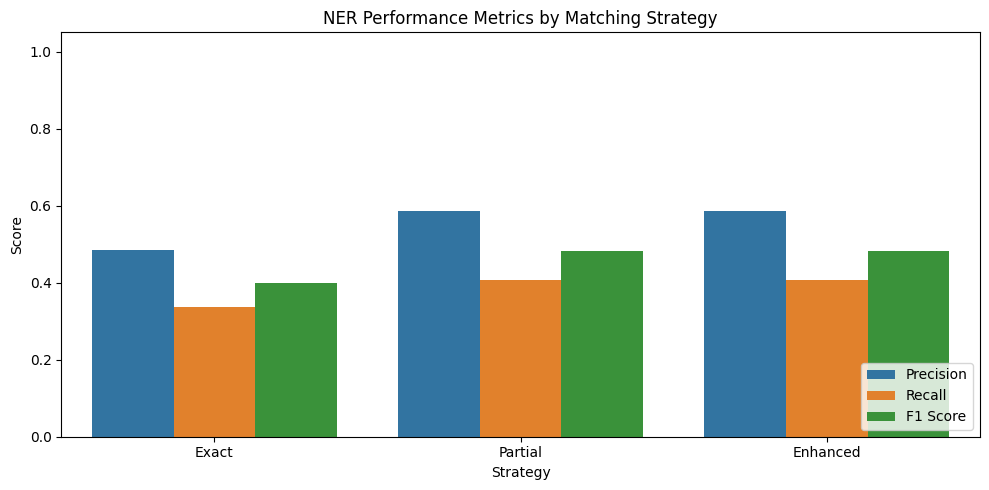

In [69]:
# LLaMA 3.2 temp 05
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_2_3b_temp5.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_2_3b_temp5_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_2_3b_temp5_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

### Chunk 512

Loaded 229 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_2_temp1.csv
Loaded 224 taxonomic terms to filter out
Removed 40 empty annotations
Removed 12 generic taxonomic terms

Post-processing complete!
Final result: 177 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_2_temp1_post.csv

Summary:
- Documents processed: 59
- Average annotations per document: 3.0
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 59 documents with 177 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 59
Common documents: 53 (77.94% coverage)
Documents only in ground truth: 15
Documents only in predictions: 6
  IDs: ['species038', 'species070', 'species322', 'species370', 'species537', 'species551']

Calculating metrics...

COMPREHENSIVE NER EVALUATION RESUL

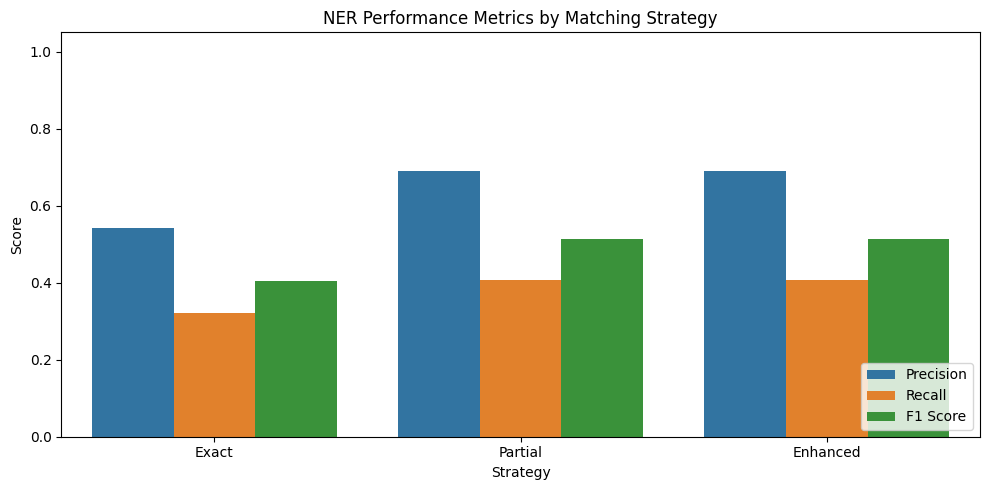

In [5]:
# LLaMA 3.2 temp 01
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_2_temp1.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_2_temp1_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_2_temp1_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 233 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_2_temp3.csv
Loaded 224 taxonomic terms to filter out
Removed 39 empty annotations
Removed 9 generic taxonomic terms

Post-processing complete!
Final result: 185 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_2_temp3_post.csv

Summary:
- Documents processed: 59
- Average annotations per document: 3.1
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 59 documents with 185 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 59
Common documents: 52 (76.47% coverage)
Documents only in ground truth: 16
Documents only in predictions: 7
  IDs: ['species038', 'species070', 'species322', 'species370', 'species537', 'species551', 'species661']

Calculating metrics...

COMPREHENSIVE NER EVA

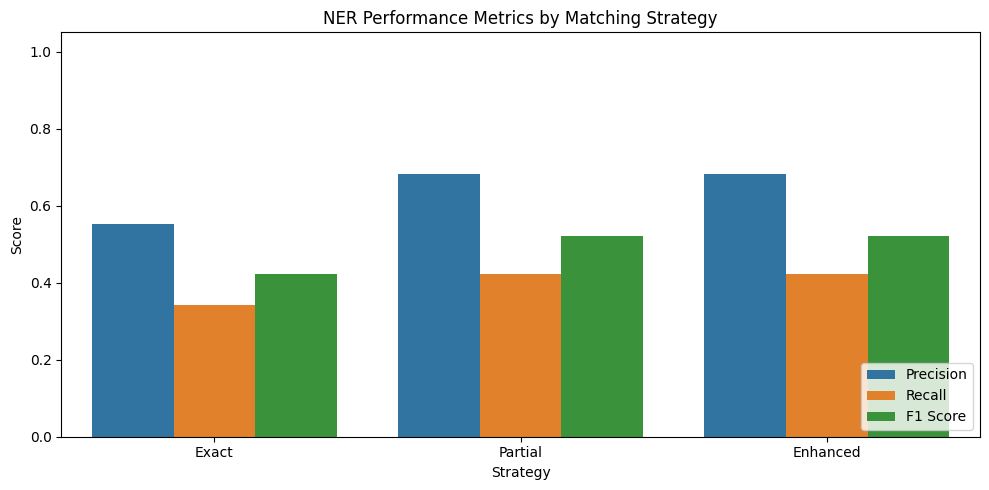

In [6]:
# LLaMA 3.2 temp 01
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_2_temp3.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_2_temp3_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_2_temp3_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 245 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_2_temp5.csv
Loaded 224 taxonomic terms to filter out
Removed 33 empty annotations
Removed 15 generic taxonomic terms

Post-processing complete!
Final result: 197 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_2_temp5_post.csv

Summary:
- Documents processed: 66
- Average annotations per document: 3.0
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 66 documents with 197 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 66
Common documents: 56 (82.35% coverage)
Documents only in ground truth: 12
Documents only in predictions: 10
  IDs: ['species038', 'species070', 'species320', 'species322', 'species370', 'species464', 'species537', 'species551', 'species584', 'species661']

C

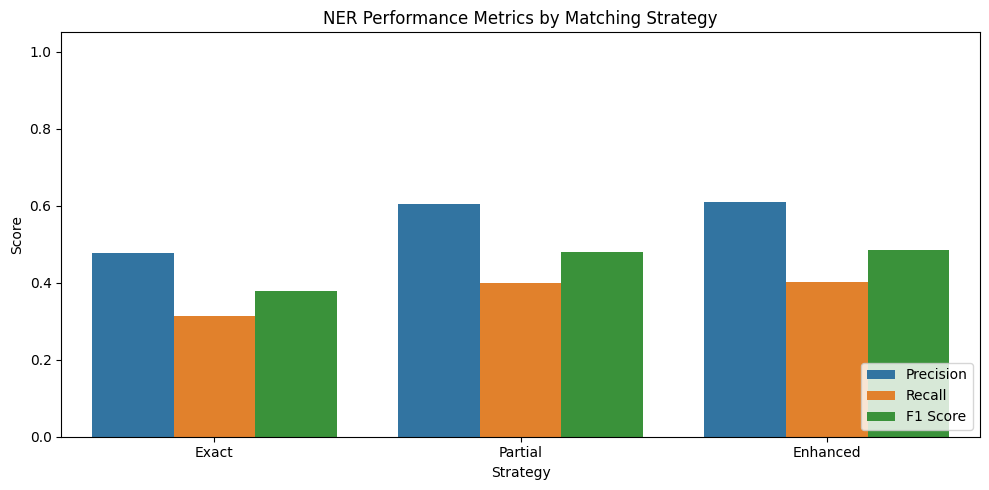

In [7]:
# LLaMA 3.2 temp 01
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_2_temp5.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_2_temp5_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_2_temp5_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

### Chunk 1024

Loaded 234 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_2_temp1.csv
Loaded 224 taxonomic terms to filter out
Removed 37 empty annotations
Removed 11 generic taxonomic terms

Post-processing complete!
Final result: 186 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_2_temp1_post.csv

Summary:
- Documents processed: 62
- Average annotations per document: 3.0
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 62 documents with 186 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 62
Common documents: 54 (79.41% coverage)
Documents only in ground truth: 14
Documents only in predictions: 8
  IDs: ['species038', 'species070', 'species132', 'species322', 'species370', 'species537', 'species551', 'species661']

Calculating metrics...

COMP

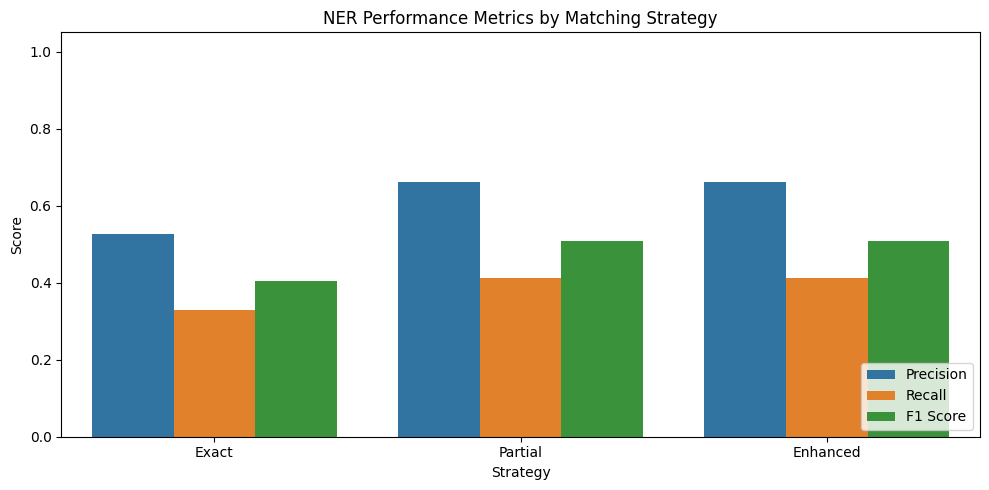

In [6]:
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_2_temp1.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_2_temp1_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_2_temp1_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 248 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_2_temp3.csv
Loaded 224 taxonomic terms to filter out
Removed 37 empty annotations
Removed 10 generic taxonomic terms

Post-processing complete!
Final result: 201 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_2_temp3_post.csv

Summary:
- Documents processed: 62
- Average annotations per document: 3.2
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 62 documents with 201 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 62
Common documents: 55 (80.88% coverage)
Documents only in ground truth: 13
Documents only in predictions: 7
  IDs: ['species038', 'species070', 'species320', 'species322', 'species537', 'species551', 'species661']

Calculating metrics...

COMPREHENSIVE NER 

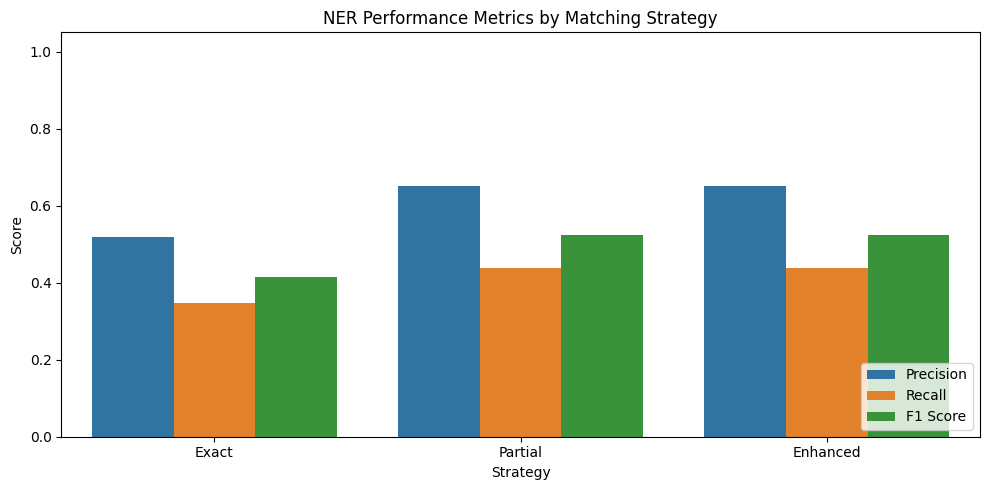

In [7]:
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_2_temp3.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_2_temp3_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_2_temp3_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 248 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_2_temp5.csv
Loaded 224 taxonomic terms to filter out
Removed 34 empty annotations
Removed 16 generic taxonomic terms

Post-processing complete!
Final result: 198 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_2_temp5_post.csv

Summary:
- Documents processed: 64
- Average annotations per document: 3.1
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 64 documents with 198 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 64
Common documents: 54 (79.41% coverage)
Documents only in ground truth: 14
Documents only in predictions: 10
  IDs: ['species038', 'species050', 'species070', 'species322', 'species370', 'species537', 'species551', 'species553', 'species661', 'species772']


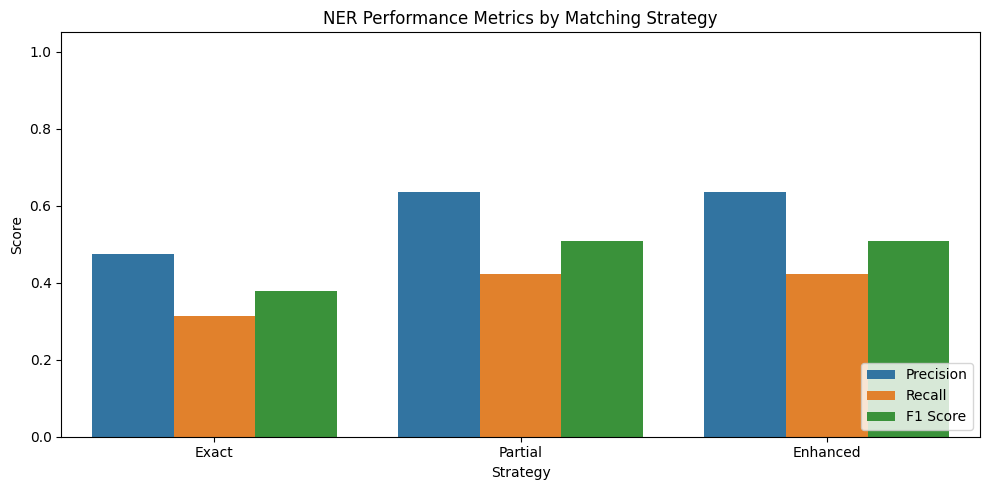

In [8]:
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_2_temp5.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_2_temp5_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_2_temp5_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

## LLaMA 3.3 70B

### Chunk 256

Loaded 351 annotations from ./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_3_temp1.csv
Loaded 224 taxonomic terms to filter out
Removed 10 empty annotations
Removed 64 generic taxonomic terms

Post-processing complete!
Final result: 277 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_3_temp1_post.csv

Summary:
- Documents processed: 86
- Average annotations per document: 3.2
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 86 documents with 277 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 86
Common documents: 65 (95.59% coverage)
Documents only in ground truth: 3
  IDs: ['species012', 'species499', 'species739']
Documents only in predictions: 21
  IDs: ['species014', 'species035', 'species038', 'species050', 'species070', 'species315', '

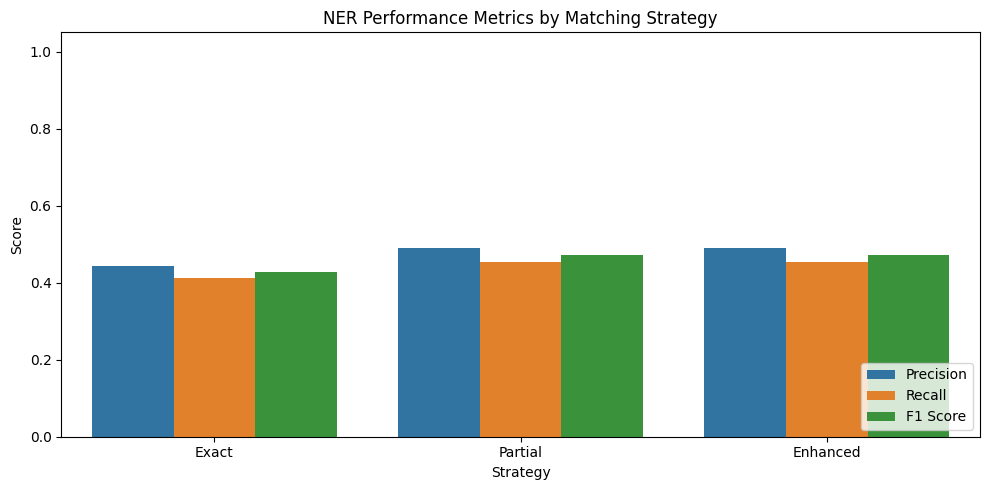

In [70]:
# LLaMA 3.3 temp 01
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_3_temp1.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_3_temp1_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_3_temp1_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 364 annotations from ./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_3_temp3.csv
Loaded 224 taxonomic terms to filter out
Removed 9 empty annotations
Removed 74 generic taxonomic terms

Post-processing complete!
Final result: 281 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_3_temp3_post.csv

Summary:
- Documents processed: 86
- Average annotations per document: 3.3
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 86 documents with 281 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 86
Common documents: 67 (98.53% coverage)
Documents only in ground truth: 1
  IDs: ['species739']
Documents only in predictions: 19
  IDs: ['species014', 'species035', 'species050', 'species070', 'species132', 'species315', 'species317', 'species320', 's

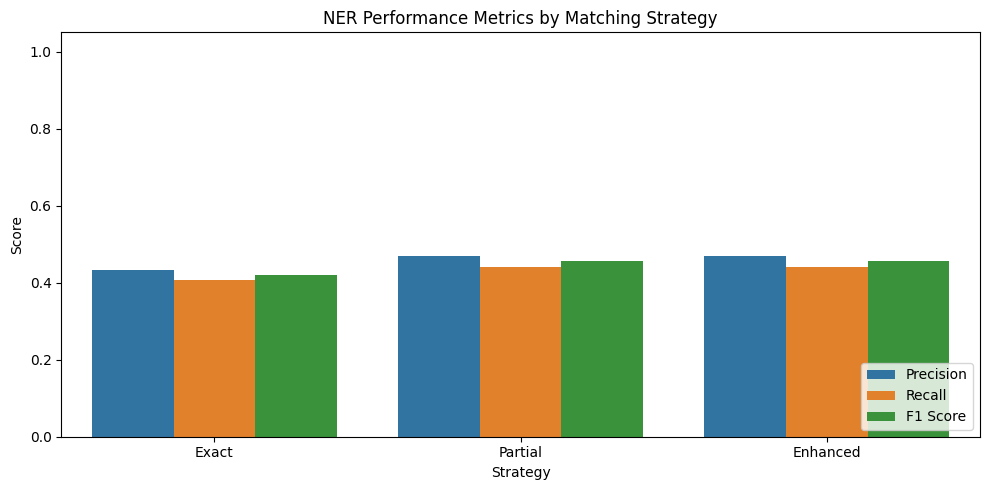

In [71]:
# LLaMA 3.3 temp 03
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_3_temp3.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_3_temp3_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_3_temp3_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 345 annotations from ./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_3_temp5.csv
Loaded 224 taxonomic terms to filter out
Removed 12 empty annotations
Removed 52 generic taxonomic terms

Post-processing complete!
Final result: 281 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_3_temp5_post.csv

Summary:
- Documents processed: 84
- Average annotations per document: 3.3
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 84 documents with 281 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 84
Common documents: 66 (97.06% coverage)
Documents only in ground truth: 2
  IDs: ['species549', 'species739']
Documents only in predictions: 18
  IDs: ['species014', 'species038', 'species050', 'species070', 'species315', 'species317', 'species320', '

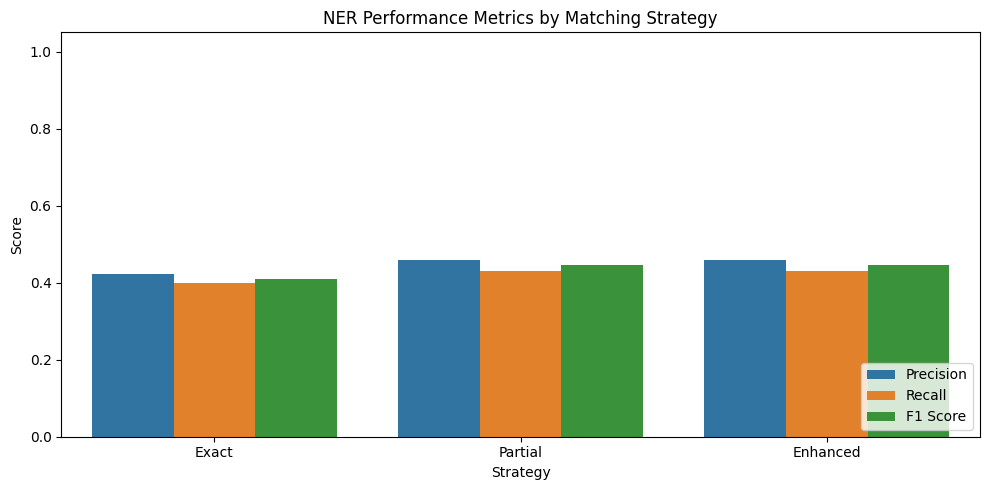

In [72]:
# LLaMA 3.3 temp 05
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama3_3_temp5.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_3_temp5_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama3_3_temp5_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

### Chunk 512

Loaded 387 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_3_temp1.csv
Loaded 229 taxonomic terms to filter out
Removed 11 empty annotations
Removed 54 generic taxonomic terms

Post-processing complete!
Final result: 322 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_3_temp1_post.csv

Summary:
- Documents processed: 85
- Average annotations per document: 3.8
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 85 documents with 322 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 85
Common documents: 65 (95.59% coverage)
Documents only in ground truth: 3
  IDs: ['species413', 'species499', 'species739']
Documents only in predictions: 20
  IDs: ['species014', 'species038', 'species050', 'species070', 'species132', 'species315', 'species3

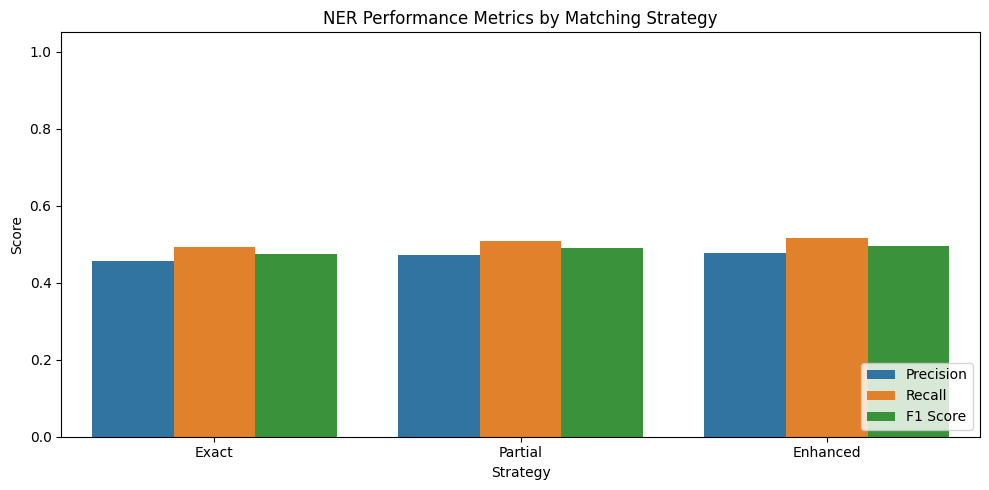

In [48]:
# LLaMA 3.3 temp 01
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_3_temp1.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_3_temp1_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_3_temp1_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 389 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_3_temp3.csv
Loaded 229 taxonomic terms to filter out
Removed 8 empty annotations
Removed 55 generic taxonomic terms

Post-processing complete!
Final result: 326 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_3_temp3_post.csv

Summary:
- Documents processed: 87
- Average annotations per document: 3.7
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 87 documents with 326 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 87
Common documents: 66 (97.06% coverage)
Documents only in ground truth: 2
  IDs: ['species499', 'species739']
Documents only in predictions: 21
  IDs: ['species014', 'species038', 'species050', 'species070', 'species132', 'species315', 'species320', 'species32

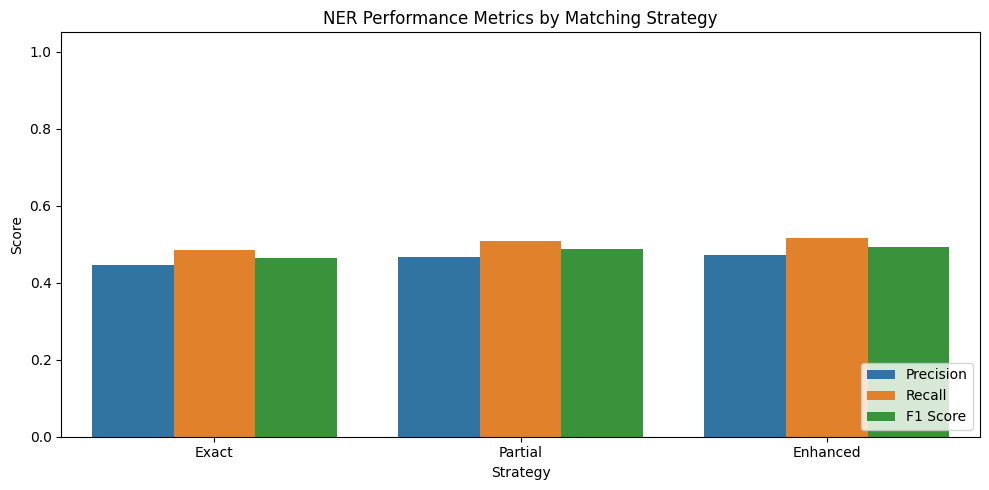

In [49]:
# LLaMA 3.3 temp 03
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_3_temp3.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_3_temp3_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_3_temp3_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 399 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_3_temp5.csv
Loaded 229 taxonomic terms to filter out
Removed 9 empty annotations
Removed 56 generic taxonomic terms

Post-processing complete!
Final result: 334 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_3_temp5_post.csv

Summary:
- Documents processed: 86
- Average annotations per document: 3.9
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 86 documents with 334 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 86
Common documents: 67 (98.53% coverage)
Documents only in ground truth: 1
  IDs: ['species739']
Documents only in predictions: 19
  IDs: ['species014', 'species038', 'species050', 'species070', 'species132', 'species315', 'species320', 'species370', 'species41

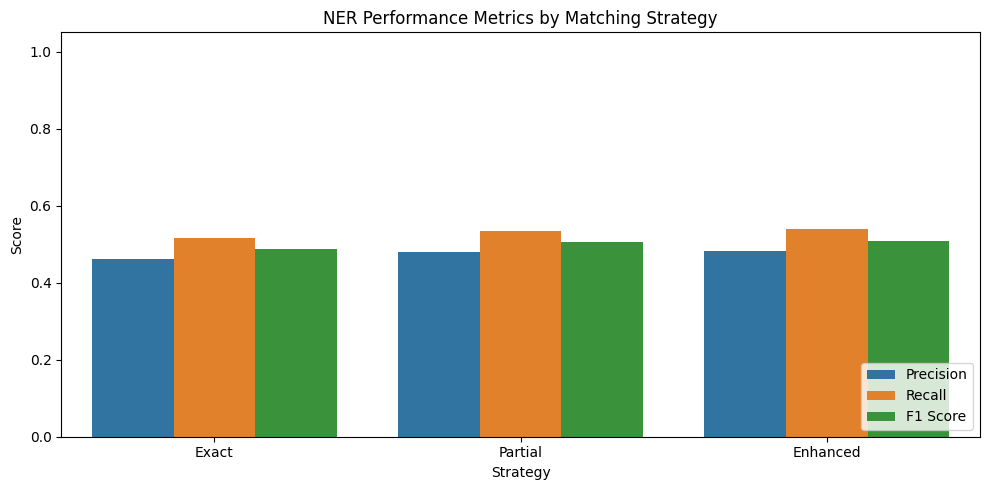

In [50]:
# LLaMA 3.3 temp 05
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama3_3_temp5.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_3_temp5_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama3_3_temp5_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

### Chunk 1024

Loaded 394 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_3_temp1.csv
Loaded 224 taxonomic terms to filter out
Removed 9 empty annotations
Removed 48 generic taxonomic terms

Post-processing complete!
Final result: 337 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_3_temp1_post.csv

Summary:
- Documents processed: 89
- Average annotations per document: 3.8
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 89 documents with 337 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 89
Common documents: 67 (98.53% coverage)
Documents only in ground truth: 1
  IDs: ['species499']
Documents only in predictions: 22
  IDs: ['species014', 'species038', 'species050', 'species070', 'species132', 'species291', 'species315', 'species317', 'species

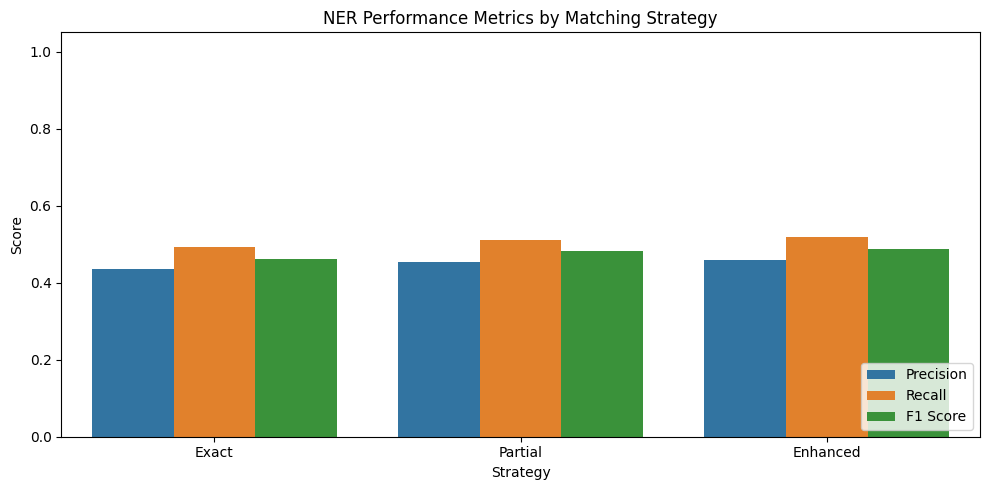

In [84]:
# LLaMA 3.3 temp 01
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_3_temp1.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_3_temp1_post.csv",
        taxonomic_terms_path="./taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_3_temp1_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 386 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_3_temp3.csv
Loaded 224 taxonomic terms to filter out
Removed 9 empty annotations
Removed 44 generic taxonomic terms

Post-processing complete!
Final result: 333 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_3_temp3_post.csv

Summary:
- Documents processed: 87
- Average annotations per document: 3.8
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 87 documents with 333 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 87
Common documents: 66 (97.06% coverage)
Documents only in ground truth: 2
  IDs: ['species499', 'species739']
Documents only in predictions: 21
  IDs: ['species014', 'species038', 'species050', 'species070', 'species132', 'species315', 'species317', 'species

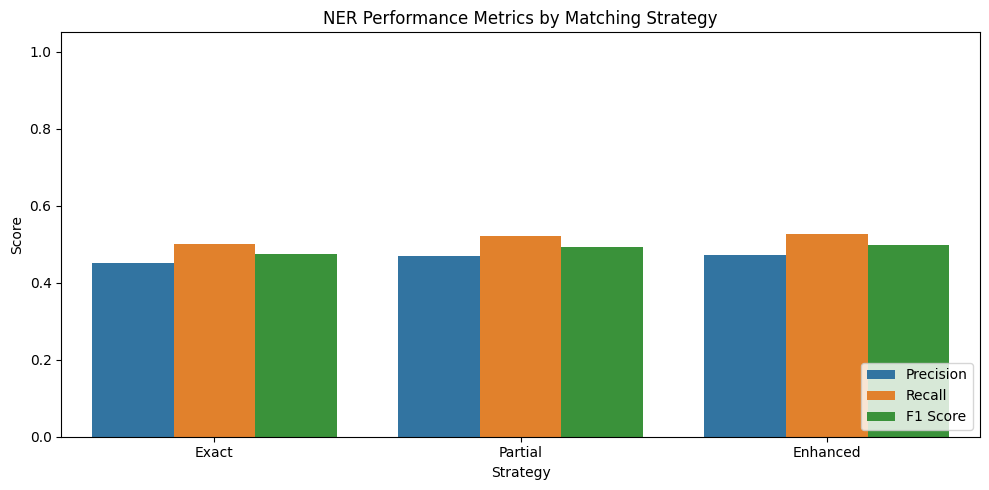

In [85]:
# LLaMA 3.3 temp 03
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_3_temp3.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_3_temp3_post.csv",
        taxonomic_terms_path="./taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_3_temp3_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 389 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_3_temp5.csv
Loaded 224 taxonomic terms to filter out
Removed 9 empty annotations
Removed 41 generic taxonomic terms

Post-processing complete!
Final result: 339 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_3_temp5_post.csv

Summary:
- Documents processed: 87
- Average annotations per document: 3.9
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 87 documents with 339 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 87
Common documents: 66 (97.06% coverage)
Documents only in ground truth: 2
  IDs: ['species499', 'species739']
Documents only in predictions: 21
  IDs: ['species014', 'species038', 'species050', 'species070', 'species132', 'species315', 'species317', 'species

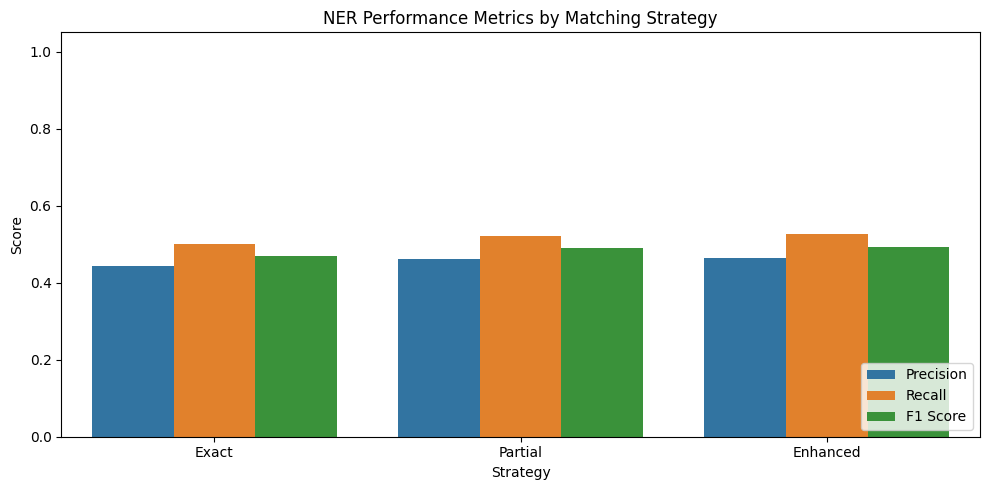

In [5]:
# LLaMA 3.3 temp 03
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama3_3_temp5.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_3_temp5_post.csv",
        taxonomic_terms_path="./taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama3_3_temp5_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

## LLaMA 4 17B Scout

### Chunk 256

Loaded 452 annotations from ./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama4_temp01.csv
Loaded 229 taxonomic terms to filter out
Removed 0 empty annotations
Removed 137 generic taxonomic terms

Post-processing complete!
Final result: 315 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama4_temp01_post.csv

Summary:
- Documents processed: 88
- Average annotations per document: 3.6
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 88 documents with 315 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 88
Common documents: 64 (94.12% coverage)
Documents only in ground truth: 4
  IDs: ['species413', 'species675', 'species731', 'species739']
Documents only in predictions: 24
  IDs: ['species014', 'species038', 'species050', 'species065', 'species070', 'sp

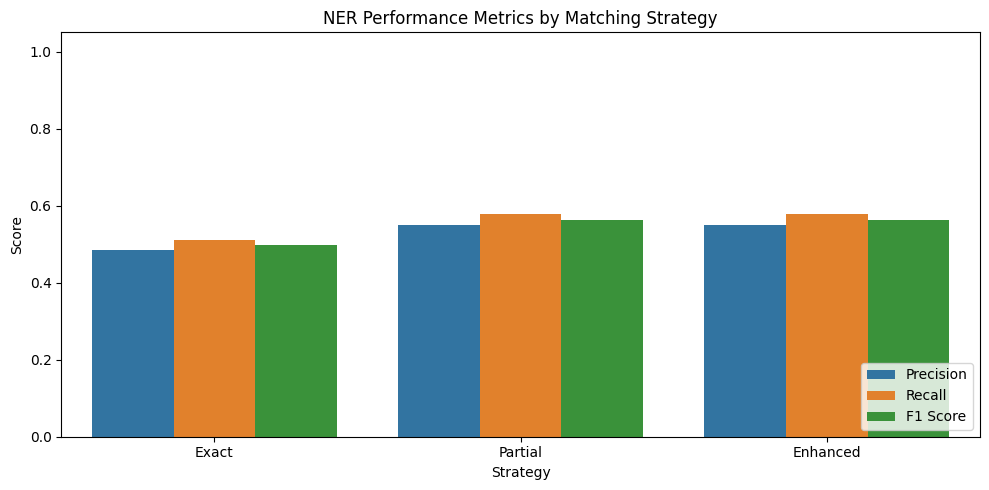

In [51]:
# LLaMA 4 temp 01
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama4_temp01.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama4_temp01_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama4_temp01_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 440 annotations from ./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama4_temp3.csv
Loaded 229 taxonomic terms to filter out
Removed 1 empty annotations
Removed 126 generic taxonomic terms

Post-processing complete!
Final result: 313 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama4_temp3_post.csv

Summary:
- Documents processed: 87
- Average annotations per document: 3.6
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 87 documents with 313 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 87
Common documents: 64 (94.12% coverage)
Documents only in ground truth: 4
  IDs: ['species413', 'species675', 'species731', 'species739']
Documents only in predictions: 23
  IDs: ['species014', 'species038', 'species050', 'species065', 'species070', 'spec

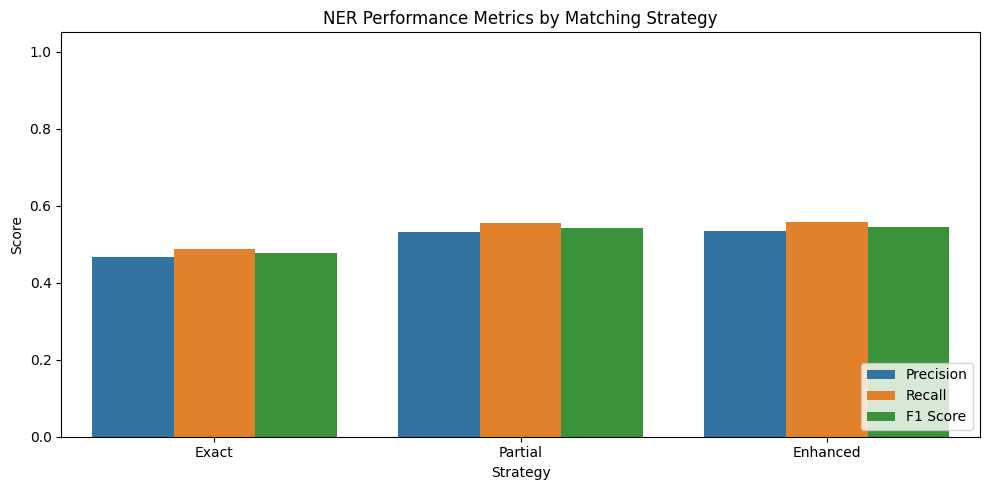

In [52]:
# LLaMA 4 temp 03
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama4_temp3.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama4_temp3_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama4_temp3_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 436 annotations from ./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama4_temp5.csv
Loaded 229 taxonomic terms to filter out
Removed 1 empty annotations
Removed 126 generic taxonomic terms

Post-processing complete!
Final result: 309 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama4_temp5_post.csv

Summary:
- Documents processed: 88
- Average annotations per document: 3.5
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 88 documents with 309 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 88
Common documents: 64 (94.12% coverage)
Documents only in ground truth: 4
  IDs: ['species413', 'species675', 'species731', 'species739']
Documents only in predictions: 24
  IDs: ['species014', 'species038', 'species050', 'species065', 'species070', 'spec

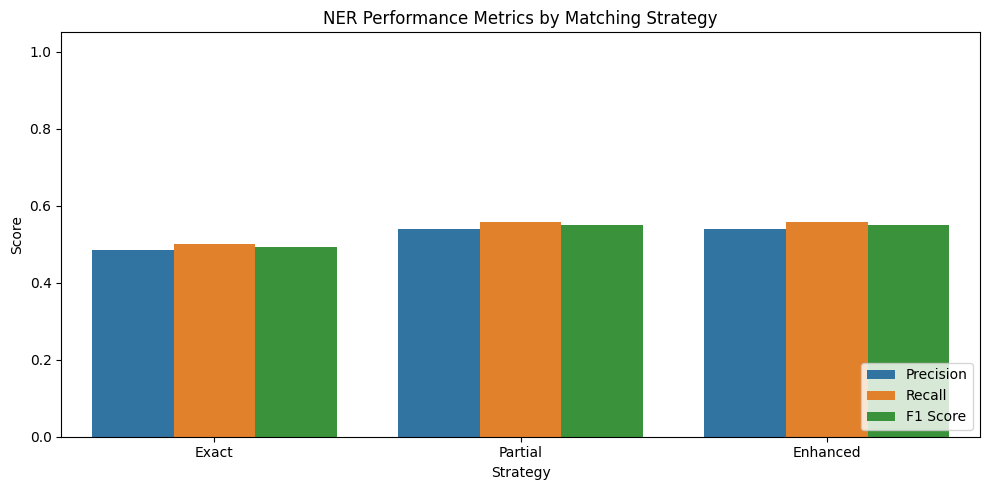

In [53]:
# LLaMA 4 temp 05
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/whole_content_results_llama4_temp5.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama4_temp5_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/whole_content_results_llama4_temp5_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

### Chunk 512

Loaded 1053 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama4_temp1.csv
Loaded 224 taxonomic terms to filter out
Removed 78 empty annotations
Removed 284 generic taxonomic terms

Post-processing complete!
Final result: 691 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama4_temp1_post.csv

Summary:
- Documents processed: 97
- Average annotations per document: 7.1
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 97 documents with 691 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 97
Common documents: 68 (100.00% coverage)
Documents only in ground truth: 0
  IDs: []
Documents only in predictions: 29
  IDs: ['species014', 'species035', 'species038', 'species050', 'species065', 'species070', 'species132', 'species315', 'species317', 'species

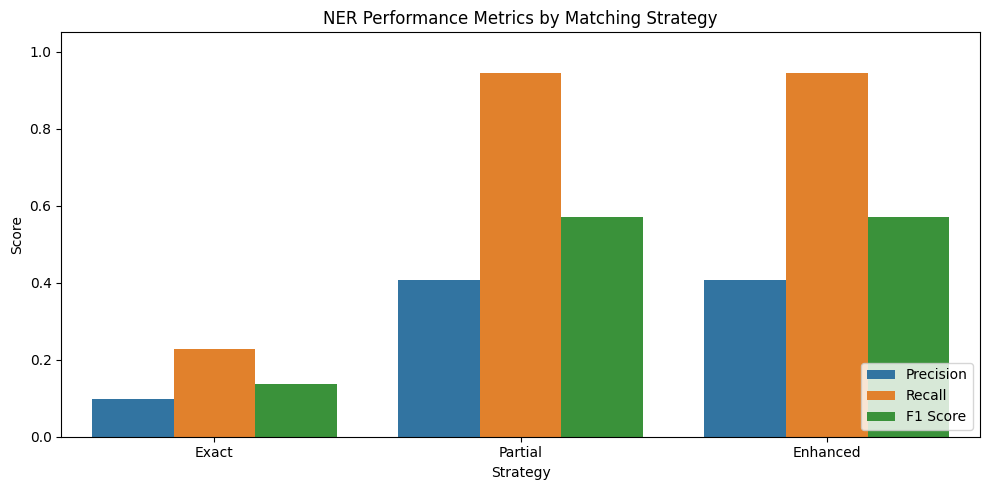

In [73]:
# LLaMA 4 temp 01
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama4_temp1.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama4_temp1_post.csv",
        taxonomic_terms_path="./taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama4_temp1_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 458 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama4_temp3.csv
Loaded 224 taxonomic terms to filter out
Removed 0 empty annotations
Removed 116 generic taxonomic terms

Post-processing complete!
Final result: 342 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama4_temp3_post.csv

Summary:
- Documents processed: 92
- Average annotations per document: 3.7
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 92 documents with 342 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 92
Common documents: 67 (98.53% coverage)
Documents only in ground truth: 1
  IDs: ['species739']
Documents only in predictions: 25
  IDs: ['species014', 'species038', 'species050', 'species065', 'species070', 'species315', 'species317', 'species320', 'species322',

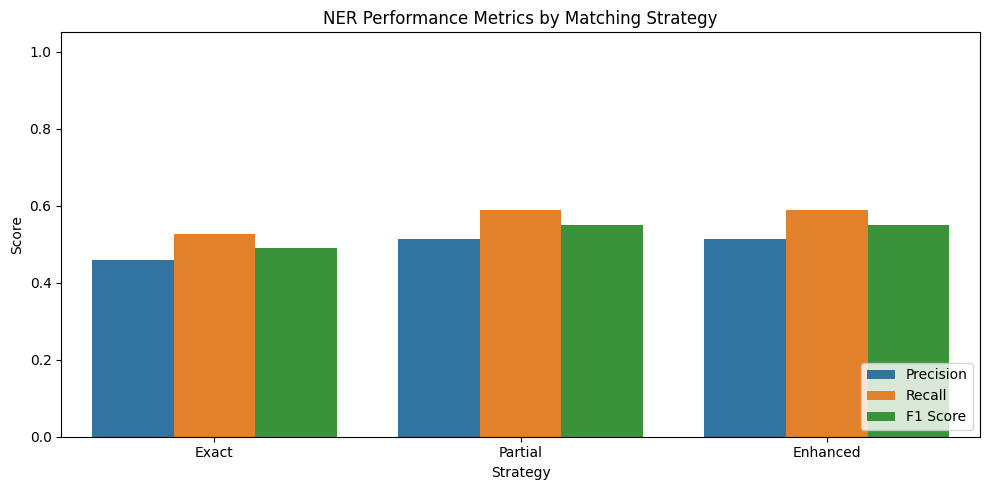

In [74]:
# LLaMA 4 temp 03
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama4_temp3.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama4_temp3_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama4_temp3_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 451 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama4_temp5.csv
Loaded 224 taxonomic terms to filter out
Removed 1 empty annotations
Removed 110 generic taxonomic terms

Post-processing complete!
Final result: 340 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama4_temp5_post.csv

Summary:
- Documents processed: 94
- Average annotations per document: 3.6
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 94 documents with 340 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 94
Common documents: 67 (98.53% coverage)
Documents only in ground truth: 1
  IDs: ['species739']
Documents only in predictions: 27
  IDs: ['species014', 'species038', 'species050', 'species065', 'species070', 'species291', 'species315', 'species317', 'species320',

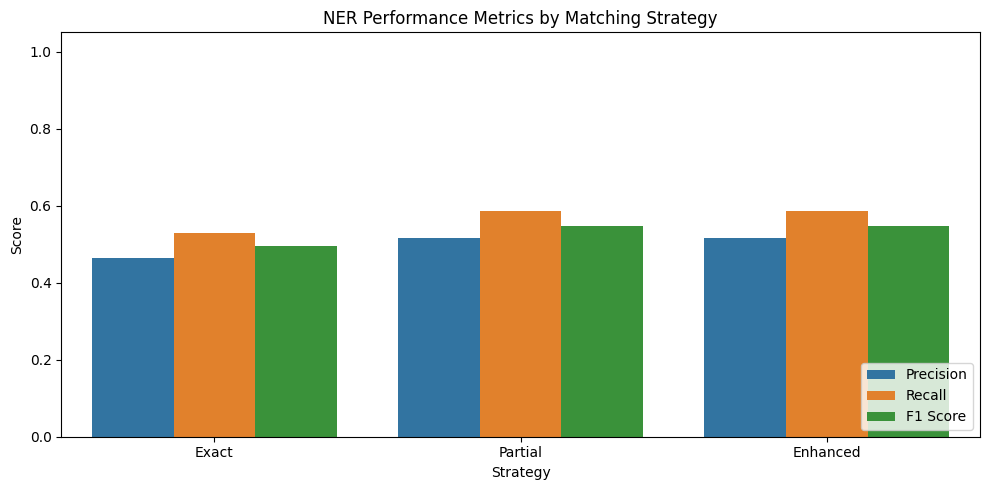

In [75]:
# LLaMA 4 temp 05
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_512_results_llama4_temp5.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama4_temp5_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_512_results_llama4_temp5_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

### Chunk 1024

Loaded 899 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama4_temp1.csv
Loaded 224 taxonomic terms to filter out
Removed 26 empty annotations
Removed 265 generic taxonomic terms

Post-processing complete!
Final result: 608 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama4_temp1_post.csv

Summary:
- Documents processed: 97
- Average annotations per document: 6.3
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 97 documents with 608 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 97
Common documents: 68 (100.00% coverage)
Documents only in ground truth: 0
  IDs: []
Documents only in predictions: 29
  IDs: ['species014', 'species038', 'species050', 'species065', 'species070', 'species291', 'species315', 'species317', 'species320', 'specie

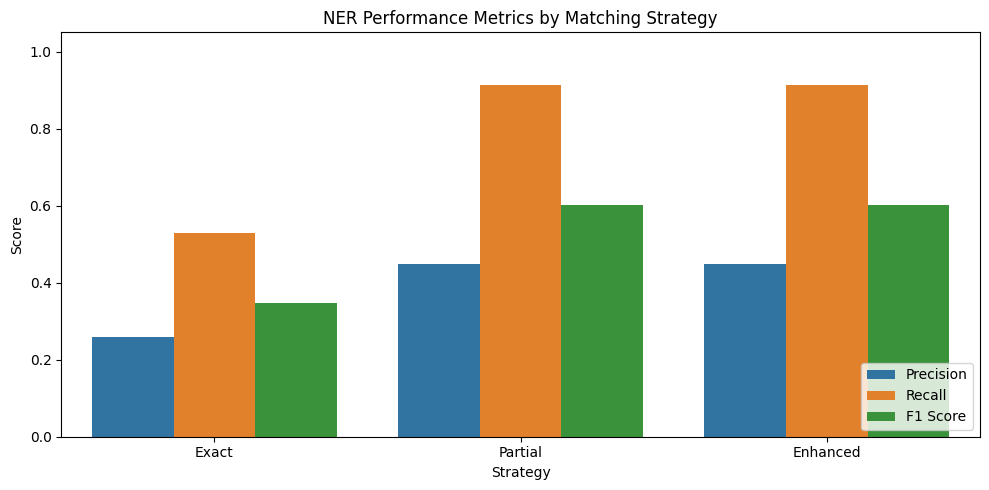

In [76]:
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama4_temp1.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama4_temp1_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama4_temp1_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 446 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama4_temp3.csv
Loaded 224 taxonomic terms to filter out
Removed 1 empty annotations
Removed 107 generic taxonomic terms

Post-processing complete!
Final result: 338 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama4_temp3_post.csv

Summary:
- Documents processed: 93
- Average annotations per document: 3.6
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 93 documents with 338 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 93
Common documents: 67 (98.53% coverage)
Documents only in ground truth: 1
  IDs: ['species739']
Documents only in predictions: 26
  IDs: ['species014', 'species038', 'species050', 'species065', 'species070', 'species291', 'species315', 'species317', 'species320

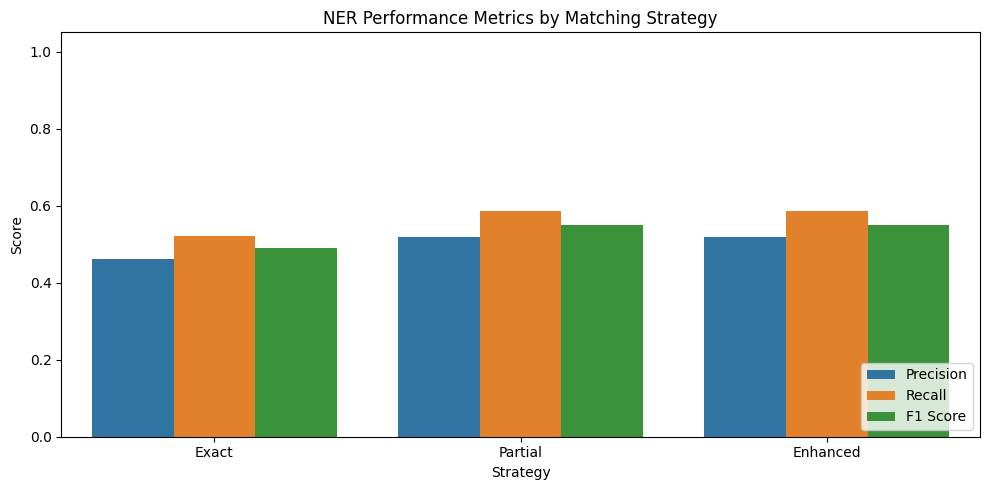

In [77]:
# temp 3
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama4_temp3.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama4_temp3_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama4_temp3_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 455 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama4_temp5.csv
Loaded 224 taxonomic terms to filter out
Removed 0 empty annotations
Removed 111 generic taxonomic terms

Post-processing complete!
Final result: 344 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama4_temp5_post.csv

Summary:
- Documents processed: 94
- Average annotations per document: 3.7
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 94 documents with 344 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 94
Common documents: 67 (98.53% coverage)
Documents only in ground truth: 1
  IDs: ['species739']
Documents only in predictions: 27
  IDs: ['species014', 'species035', 'species038', 'species050', 'species065', 'species070', 'species291', 'species315', 'species317

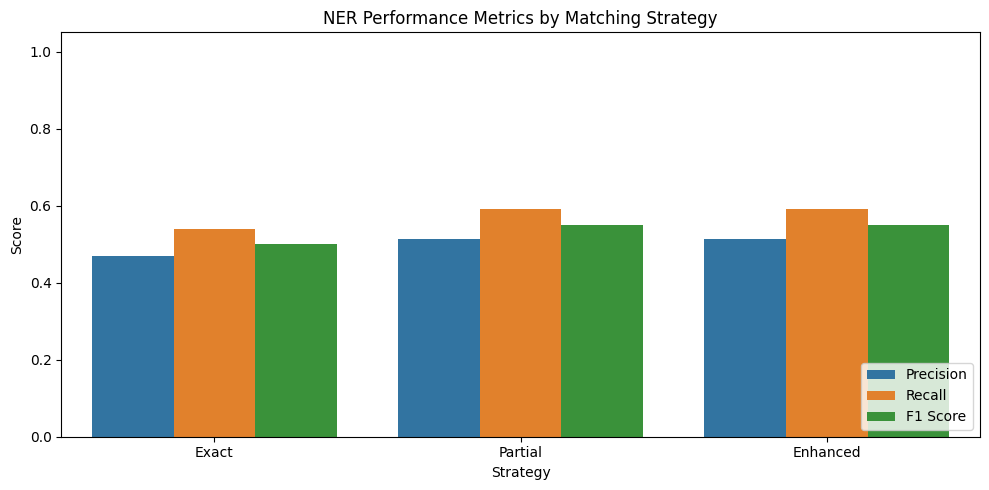

In [83]:
# temp 5
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_results_llama4_temp5.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama4_temp5_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_results_llama4_temp5_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

### Final Decision over Best Performance of the models 

## the best model in all experimnets is LLaMA 4 1024 temp 05 
- Recall: 59
- F1: 55

Loaded 107 annotations from ./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_llama4_allowed_docs_temp5_best_model_result.csv
Loaded 224 taxonomic terms to filter out
Removed 0 empty annotations
Removed 9 generic taxonomic terms

Post-processing complete!
Final result: 98 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_llama4_allowed_docs_temp5_best_model_result_post.csv

Summary:
- Documents processed: 18
- Average annotations per document: 5.4
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 18 documents with 98 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 18
Common documents: 18 (26.47% coverage)
Documents only in ground truth: 50
Documents only in predictions: 0
  IDs: []

Calculating metrics...

COMPREHENSIVE NER EVALUATION RESULTS

Dataset Information:
├── Ground truth 

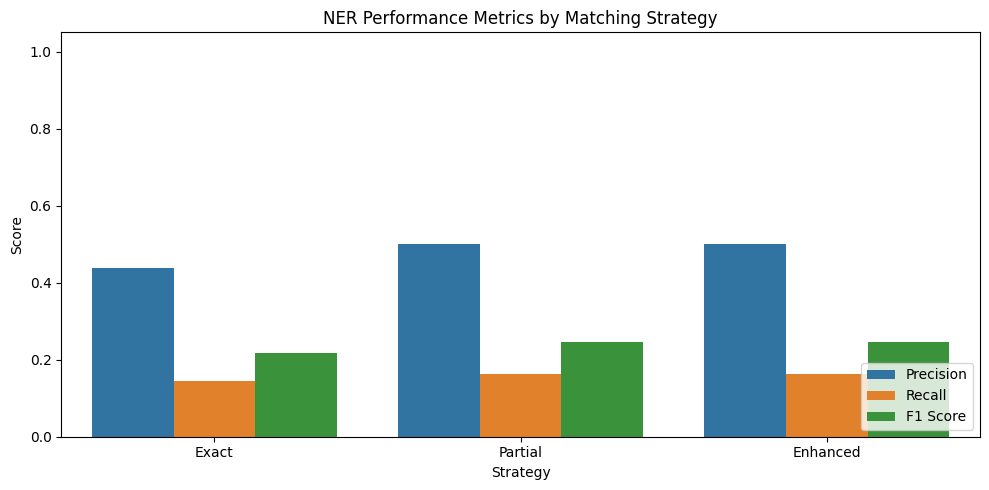

In [8]:
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/chunk_1024_llama4_allowed_docs_temp5_best_model_result.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_llama4_allowed_docs_temp5_best_model_result_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/chunk_1024_llama4_allowed_docs_temp5_best_model_result_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)

Loaded 110 annotations from ./s800_results/llama3_1_FS_results_on_zoo/SpeciesInteraction_entities.csv
Loaded 224 taxonomic terms to filter out
Removed 0 empty annotations
Removed 4 generic taxonomic terms

Post-processing complete!
Final result: 106 annotations saved to ./s800_results/llama3_1_FS_results_on_zoo/post/SpeciesInteraction_entities_post.csv

Summary:
- Documents processed: 18
- Average annotations per document: 5.9
ENHANCED NER PIPELINE EVALUATION
Loading ground truth from: ./s800/s800-Groundtruth.csv
Loaded ground truth for 68 documents with 299 entities
Preparing predictions...
Prepared predictions for 18 documents with 106 entities

Document ID Analysis:
Ground truth documents: 68
Prediction documents: 18
Common documents: 18 (26.47% coverage)
Documents only in ground truth: 50
Documents only in predictions: 0
  IDs: []

Calculating metrics...

COMPREHENSIVE NER EVALUATION RESULTS

Dataset Information:
├── Ground truth entities: 299
├── Predicted entities: 106
├── Total 

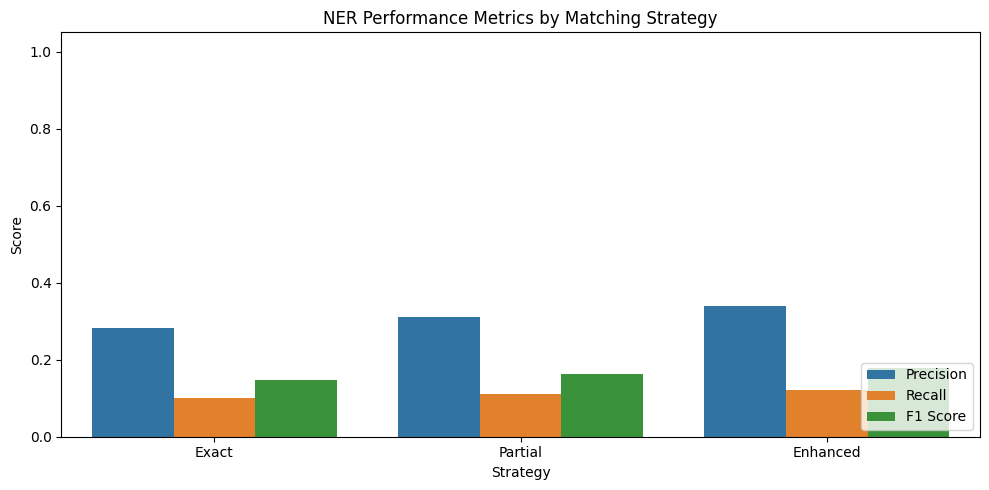

In [6]:
cleaned_results = simple_post_process(
        input_csv_path="./s800_results/llama3_1_FS_results_on_zoo/SpeciesInteraction_entities.csv",
        output_csv_path="./s800_results/llama3_1_FS_results_on_zoo/post/SpeciesInteraction_entities_post.csv",
        taxonomic_terms_path="taxonomic_terms_list.txt"
    )
results = evaluate_ner_pipeline(
    predictions_file="./s800_results/llama3_1_FS_results_on_zoo/post/SpeciesInteraction_entities_post.csv",
    ground_truth_file='./s800/s800-Groundtruth.csv',
    use_enhanced_matching=True,
    use_optimal_matching=False,
    fuzzy_threshold=0.7,      
    position_tolerance=3,      
    verbose=False
)
plot_performance_metrics_bar(results)